In [2]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU is available.')
else:
    print('No GPU is available.')
# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


c:\Users\sudha\py10\lib\site-packages\tensorflow\python\framework\dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
c:\Users\sudha\py10\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


GPU is available.


In [3]:
import gym_super_mario_bros
from gym.spaces import Box
from gym import Wrapper
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
import cv2
import numpy as np
import subprocess as sp

""" 
 Contains Monitor class to preorpcess and record
"""
class Monitor:
    def __init__(self, width, height, saved_path):

        self.command = ["ffmpeg", "-y", "-f", "rawvideo", "-vcodec", "rawvideo", "-s", "{}X{}".format(width, height),
                        "-pix_fmt", "rgb24", "-r", "60", "-i", "-", "-an", "-vcodec", "mpeg4", saved_path]
        try:
            self.pipe = sp.Popen(self.command, stdin=sp.PIPE, stderr=sp.PIPE)
        except FileNotFoundError:
            pass

    def record(self, image_array):
        try:
            self.pipe = sp.Popen(self.command, stdin=sp.PIPE, stderr=sp.PIPE)
        except FileNotFoundError as e:
            print(f"Error creating Monitor: {e}")



def process_frame(frame):
    if frame is not None:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84))[None, :, :] / 255.
        return frame
    else:
        return np.zeros((1, 84, 84))


# class CustomReward(Wrapper):
#     def __init__(self, env=None, monitor=None):
#         super(CustomReward, self).__init__(env)
#         self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
#         self.curr_score = 0
#         if monitor:
#             self.monitor = monitor
#         else:
#             self.monitor = None

#     def step(self, action):
#         state, reward, done, info = self.env.step(action)
#         if self.monitor:
#             self.monitor.record(state)
#         state = process_frame(state)
#         reward += (info["score"] - self.curr_score) / 40.
#         self.curr_score = info["score"]
#         if done:
#             if info["flag_get"]:
#                 reward += 100
#             else:
#                 reward -= 50
#         return state, reward *0.05, done, info


class CustomReward(Wrapper):
    def __init__(self, env=None, monitor=None):
        super(CustomReward, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
        self.prev_x_position = 0
        self.time_penalty = -0.01
        if monitor:
            self.monitor = monitor
        else:
            self.monitor = None

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if self.monitor:
            self.monitor.record(state)
        state = process_frame(state)
        # Calculate distance traveled (reward proportional to x-position increase)
        x_position = info["x_pos"]
        reward += (x_position - self.prev_x_position) * 0.1
        self.prev_x_position = x_position

        # Apply time penalty
        reward += self.time_penalty
        if done:
            if info["flag_get"]:
                reward += 100
            else:
                reward -= 50
        return state, reward *0.05, done, info
    
    def reset(self):
        self.prev_x_position = 0
        return process_frame(self.env.reset())

    # def reset(self):
    #     self.curr_score = 0
    #     return process_frame(self.env.reset())


class CustomSkipFrame(Wrapper):
    def __init__(self, env, skip=4):
        super(CustomSkipFrame, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(skip, 84, 84))
        self.skip = skip
        self.states = np.zeros((skip, 84, 84), dtype=np.float32)

    def step(self, action):
        total_reward = 0
        last_states = []
        for i in range(self.skip):
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if i >= self.skip /2:
                last_states.append(state)
            if done:
                self.reset()
                return self.states[None, :, :, :].astype(np.float32), total_reward, done, info
        max_state = np.max(np.concatenate(last_states,0), 0)
        self.states[:-1] = self.states[1:]
        self.states[-1] = max_state
        return self.states[None, :, :, :].astype(np.float32), total_reward, done, info


    def reset(self):
        state = self.env.reset()
        self.states = np.concatenate([state for _ in range(self.skip)], 0)
        return self.states[None, :, :, :].astype(np.float32)


def create_train_env(actions, output_path=None):
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
    if output_path:
        monitor = Monitor(256, 240, output_path)
    else:
        monitor = None

    env = JoypadSpace(env, actions)
    env = CustomReward(env, monitor)
    env = CustomSkipFrame(env)
    return env


import torch.multiprocessing as mp

class MultipleEnvironments:
    def __init__(self, action_type, num_envs, output_path=None):
        self.agent_conns, self.env_conns = zip(*[mp.Pipe() for _ in range(num_envs)])
        if action_type == "right":
            actions = RIGHT_ONLY
            print("Action Right SET")
        elif action_type == "simple":
            actions = SIMPLE_MOVEMENT
            print("Action Simple Movements SET")
        else:
            actions = COMPLEX_MOVEMENT
            print("Action Complex SET")
        self.envs = [create_train_env(actions, output_path=output_path) for _ in range(num_envs)]
        print("sself env done")
        self.num_states = self.envs[0].observation_space.shape[0]
        print("sefl state done")
        self.num_actions = len(actions)
        print("Action done SET")
            
        for index in range(num_envs):
            print("Action: Startring process")
            process = mp.Process(target=self.run, args=(index,))
            print("Action: process IniI")
            process.start()
            print("Action: process almost done")
            self.env_conns[index].close()
        print("Environments created and processes started.")

    def run(self, index):
        self.agent_conns[index].close()
        while True:
            request, action = self.env_conns[index].recv()
            print(f"Environment {index} received request: {request}")
            if request == "step":
                print(f"Environment {index} is stepping with action: {action.item()}")
                self.env_conns[index].send(self.envs[index].step(action.item()))
            elif request == "reset":
                print(f"Environment {index} is resetting")
                self.env_conns[index].send(self.envs[index].reset())
            else:
                raise NotImplementedError


PPO Model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, initializers

class PPO(tf.keras.Model):
    def __init__(self, num_inputs, num_actions):
        super(PPO, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', input_shape=num_inputs)
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.linear = tf.keras.layers.Dense(512, activation='relu')
        self.critic_linear = tf.keras.layers.Dense(1)
        self.actor_linear = tf.keras.layers.Dense(num_actions)
        # No need for _initialize_weights method if using default initializations

    def call(self, inputs):
        x = tf.nn.relu(self.conv1(inputs))
        x = tf.nn.relu(self.conv2(x))
        x = tf.nn.relu(self.conv3(x))
        x = tf.nn.relu(self.conv4(x))
        x = self.flatten(x)
        x = tf.nn.relu(self.linear(x))
        actor_output = self.actor_linear(x)
        critic_output = self.critic_linear(x)
        return actor_output, critic_output

Train processes

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [7]:
# !python -m pip install tensorflow_probability==0.12.2

In [8]:
import warnings

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
import timeit
from tensorboardX import SummaryWriter
import numpy as np
import tensorflow_probability as tfp

from collections import deque

In [10]:
# def eval(opt, global_model, num_states, num_actions):
#     tf.random.set_seed(123)
#     if opt.action_type == "right":
#         actions = RIGHT_ONLY
#     elif opt.action_type == "simple":
#         actions = SIMPLE_MOVEMENT
#     else:
#         actions = COMPLEX_MOVEMENT
#     env = create_train_env(actions=actions)
#     local_model = PPO(num_states, num_actions)
#     # local_model.evaluate()
#     state = tf.convert_to_tensor(env.reset())
#     done = True
#     curr_step = 0
#     actions = deque(maxlen=opt.max_actions)
#     while True:
#         curr_step +=1
#         if done:
#             local_model.set_weights(global_model.get_weights())
#             logits, value = local_model(state)
#             policy = tf.nn.softmax(logits, dim=1)
#             action = tf.argmax(policy).item()
#             state, reward, done, info = env.step(action)
#            # Uncomment following lines if you want to save model whenever level is completed
#             if info["flag_get"]:
#                 print("Finished")
#                 local_model.saved_model("{}/ppo_super_mario_bros_{".format(opt.saved_path,curr_step))

#             env.render()
#             actions.append(action)
#             if curr_step > opt.num_global_steps or actions.count(actions[0]) == actions.maxlen:
#                 done = True
#             if done:
#                 curr_step = 0
#                 actions.clear()
#                 state = env.reset()
#             state = tf.convert_to_tensor(state)


c:\Users\sudha\py10\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(


Before processing:


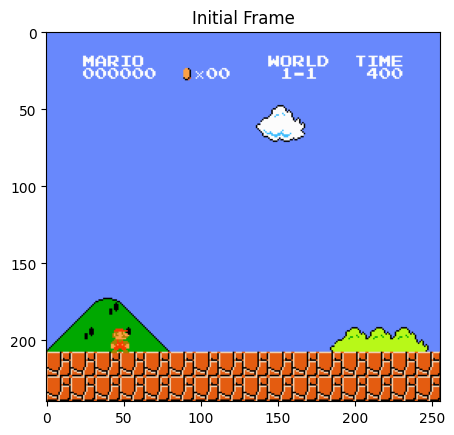


After processing:


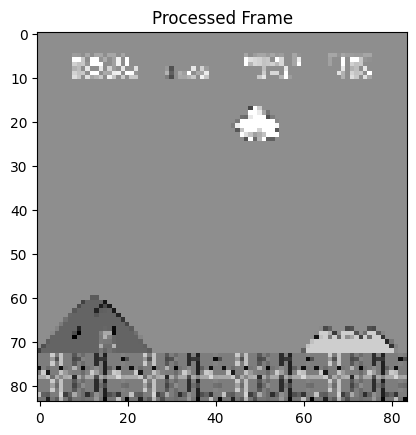

In [11]:
import gym
import gym_super_mario_bros
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_frame(frame):
    if frame is not None:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84))[None, :, :] / 255.
        return frame
    else:
        return np.zeros((1, 84, 84))

# Create the Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Before applying the process_frame function
initial_frame = env.reset()
print("Before processing:")

# Plot the initial frame
plt.figure()
plt.imshow(initial_frame)
plt.title("Initial Frame")
plt.show()

# Process the initial frame
processed_frame = process_frame(initial_frame)
print("\nAfter processing:")

# Plot the processed frame
plt.figure()
plt.imshow(processed_frame[0, :, :], cmap='gray')
plt.title("Processed Frame")
plt.show()

# Close the environment after processing
env.close()


Running for 1000 EP

In [12]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
from argparse import Namespace
import multiprocessing as _mp
import shutil
import tensorflow as tf
import warnings
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_args():
    args = Namespace(
        action_type="COMPLEX_MOVEMENT",
        lr=0.00001,
        gamma=0.95,
        tau=1.0,
        beta=0.01,
        num_local_steps=100,
        num_processes=2,
        save_interval=250,
        # max_actions=200,
        log_path="tensorboard/a3c_super_mario_bros",
        saved_path="trained_models",
        load_from_previous_stage=False,
        num_epochs= 10,
        batch_size = 10,
        epsilon = 0.3,
        output_path = "output"
    )
    return args


In [13]:
# from tensorflow_probability import distributions as tfd

In [14]:
#  envs = create_train_env(actions=RIGHT_ONLY)
#  print(f"states : {envs.observation_space.shape}")
#  print(f"actions : {envs.action_space.n}")

In [15]:

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tensorflow.keras.callbacks import ModelCheckpoint


Total reward with the saved model: 60.32699999999996
Total reward during testing: 60.32699999999996


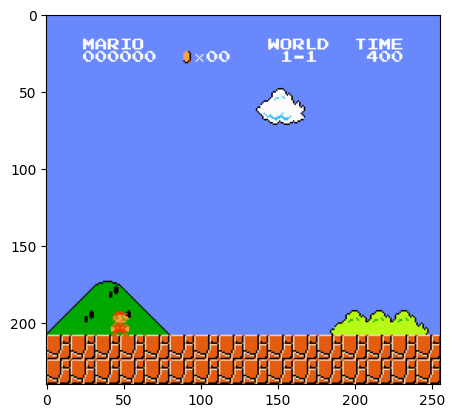

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from argparse import Namespace
import cv2  # Import OpenCV

# Import your environment creation function and PPO model definition here
# Assuming COMPLEX_MOVEMENT, create_train_env, and PPO are imported

def test_saved_model(opt, video_path="PPOv2.mp4"):
    # Load the saved model
    np.random.seed(36)
    loaded_model = tf.keras.models.load_model("{}/ppo_super_mario_bros_v2".format(opt.saved_path))

    # Create the environment
    env = create_train_env(actions=COMPLEX_MOVEMENT)
    state = env.reset()

    done = False
    total_reward = 0

    # Set up video writer
    height, width, _ = env.render(mode='rgb_array').shape
    video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

    while not done:
        # Forward pass through the loaded model to get the action probabilities
        logits, _ = loaded_model(state)
        action_probs = tf.nn.softmax(logits, axis=1).numpy()

        # Sample an action from the probability distribution
        action = np.random.choice(len(action_probs[0]), p=action_probs[0])

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        # Accumulate total reward
        total_reward += reward

        # Render the environment
        frame = env.render(mode='rgb_array')

        # Convert RGB to BGR before writing to video
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(bgr_frame)

        # Display the frame (optional)
        display(plt.imshow(frame))
        clear_output(wait=True)


    env.close()
    video_writer.release()  # Release the video writer

    print(f"Total reward with the saved model: {total_reward}")
    return total_reward

def train_and_test(opt, total_ep):
    # Your training code here...

    # After training, test the saved model
    test_total_reward = test_saved_model(opt)
    print(f"Total reward during testing: {test_total_reward}")

if __name__ == "__main__":
    opt = get_args()
    train_and_test(opt, total_ep=1000)


Total reward with the saved model: 31.731000000000027
Total reward during testing: 31.731000000000027


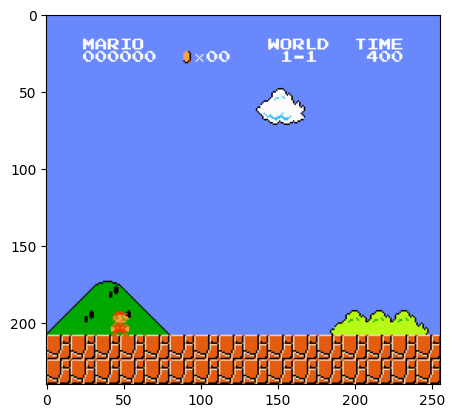

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from argparse import Namespace
import cv2  # Import OpenCV

# Import your environment creation function and PPO model definition here
# Assuming COMPLEX_MOVEMENT, create_train_env, and PPO are imported

def test_saved_model(opt, video_path="PPOv1.mp4"):
    # Load the saved model
    np.random.seed(36)
    loaded_model = tf.keras.models.load_model("{}/ppo_super_mario_bros".format(opt.saved_path))

    # Create the environment
    env = create_train_env(actions=COMPLEX_MOVEMENT)
    state = env.reset()

    done = False
    total_reward = 0

    # Set up video writer
    height, width, _ = env.render(mode='rgb_array').shape
    video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

    while not done:
        # Forward pass through the loaded model to get the action probabilities
        logits, _ = loaded_model(state)
        action_probs = tf.nn.softmax(logits, axis=1).numpy()

        # Sample an action from the probability distribution
        action = np.random.choice(len(action_probs[0]), p=action_probs[0])

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        # Accumulate total reward
        total_reward += reward

        # Render the environment
        frame = env.render(mode='rgb_array')

        # Convert RGB to BGR before writing to video
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(bgr_frame)

        # Display the frame (optional)
        display(plt.imshow(frame))
        clear_output(wait=True)


    env.close()
    video_writer.release()  # Release the video writer

    print(f"Total reward with the saved model: {total_reward}")
    return total_reward

def train_and_test(opt, total_ep):
    # Your training code here...

    # After training, test the saved model
    test_total_reward = test_saved_model(opt)
    print(f"Total reward during testing: {test_total_reward}")

if __name__ == "__main__":
    opt = get_args()
    train_and_test(opt, total_ep=1000)
